In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-11-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : gxpP2Sdg 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

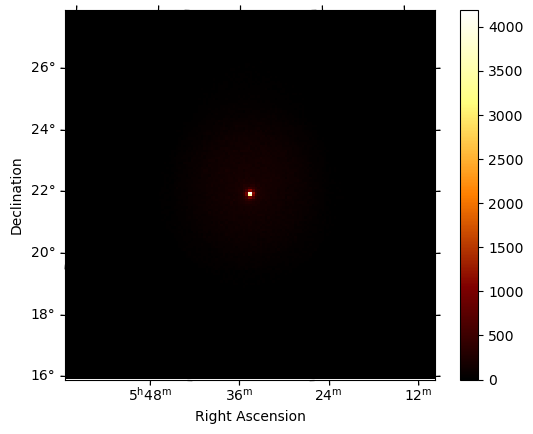

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_load.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_load)

## Single Cases

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

bias = 0
sigma = 1.77


sys = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0, 
                        tilt = 0,
                          bias = bias, 
                         sigma = sigma,
                        rnd = False)
zero = 1e-2
penalising_invcovmatrix = np.zeros((4, 4))
if bias ==0 :
    b_ = zero
else:
    b_ = bias
np.fill_diagonal(penalising_invcovmatrix, [1/zero**2, 1/zero**2, 1/b_**2, 1/sigma**2])

dataset = sys.create_dataset()
dataset_N = sys.create_dataset_N()
dataset_N.models.parameters['bias'].frozen = True

dataset_N.penalising_invcovmatrix = penalising_invcovmatrix

dataset_N.models.parameters['sigma'].frozen = True
dataset.models.parameters['sigma'].frozen = True

In [5]:
%%time
fit = Fit(store_trace=False)
result = fit.run(dataset)


CPU times: user 1.17 s, sys: 25.7 ms, total: 1.2 s
Wall time: 1.2 s


CPU times: user 40.1 s, sys: 4.23 s, total: 44.3 s
Wall time: 44.4 s


<AxesSubplot: >

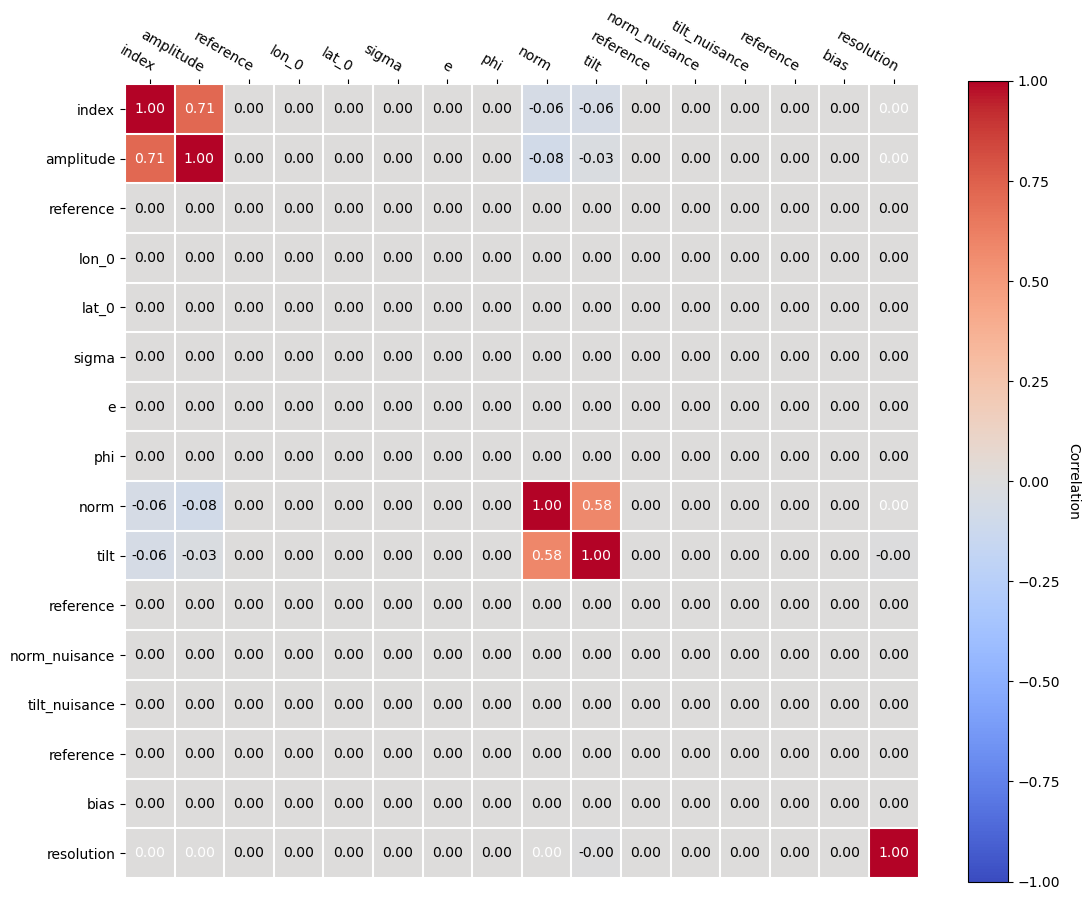

In [6]:
%%time
fit_N = Fit(store_trace=False)
result_N = fit_N.run(dataset_N)
dataset_N.models.covariance = fit_N.covariance(dataset_N).matrix
dataset_N.models.covariance.plot_correlation()

## Correlation

In [7]:
from gammapy.modeling.fit import Registry
registry= Registry()

def covariance_ (fit_compute, datasets_compute):
    #parameters = Parameters.from_stack([datasets_compute.models.parameters])
    parameters = datasets_compute.models.parameters
    parameters = parameters.free_parameters
    kwargs = fit_compute.covariance_opts.copy()
    kwargs["minuit"] = fit_compute.minuit
    backend = kwargs.pop("backend", fit_compute.backend)
    compute = registry.get("covariance", backend)

    with parameters.restore_status():
        if fit_compute.backend == "minuit":
            method = "hesse"
        else:
            method = ""
        factor_matrix, info = compute(
            parameters=parameters, function=datasets_compute.stat_sum, **kwargs
        )
        covariance = Covariance.from_factor_matrix(
            parameters=parameters, matrix=factor_matrix
        )

        #covariance = covariance.get_subcovariance(parameters_)
    return covariance

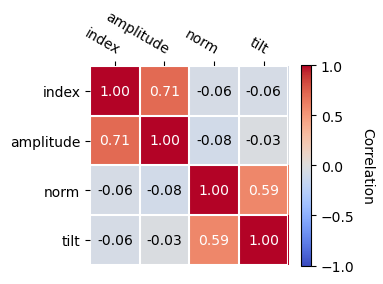

In [8]:
covariance  = covariance_(fit, dataset)
covariance.plot_correlation()


fig = plt.gcf()
fig.savefig("plots/3_corr_matrix_standard.png")

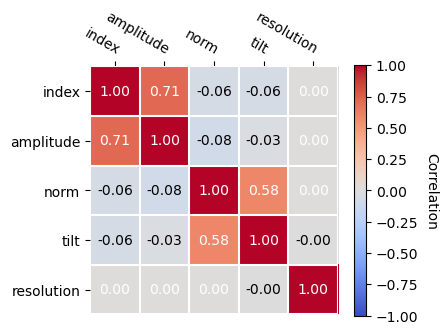

In [9]:
covariance_N  = covariance_(fit_N, dataset_N)
covariance_N.plot_correlation()


fig = plt.gcf()
fig.savefig("plots/3_corr_matrix_nuisance.png")

In [10]:
print(dataset_N.models)


DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.637   +/-    0.09             
    amplitude                     :   1.19e-12   +/- 1.1e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                 (frozen):      0.019       deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : dataset N-bkg
  Datasets names            : ['dataset N']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
   

In [11]:
print(dataset_N.models.parameters['resolution'].error)

0.0003338595209305661


In [12]:
print(dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.638   +/-    0.09             
    amplitude                     :   1.19e-12   +/- 1.1e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                 (frozen):      0.019       deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : -xejhj_Q-bkg
  Datasets names            : ['-xejhj_Q']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    n

In [13]:
for p in ['amplitude', 'index', 'sigma', 'norm', 'tilt']:
    print(p)
    print(dataset_N.models.parameters[p].error)
    print(dataset.models.parameters[p].error)

    print()


amplitude
1.1396677703102847e-13
1.1244882006588845e-13

index
0.0936891753791954
0.09498407251779381

sigma
0.0
0.0

norm
0.0020673343153003463
0.002065475674058018

tilt
0.0019613945872148496
0.001961073799852151



(<WCSAxesSubplot: >,
 <AxesSubplot: xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

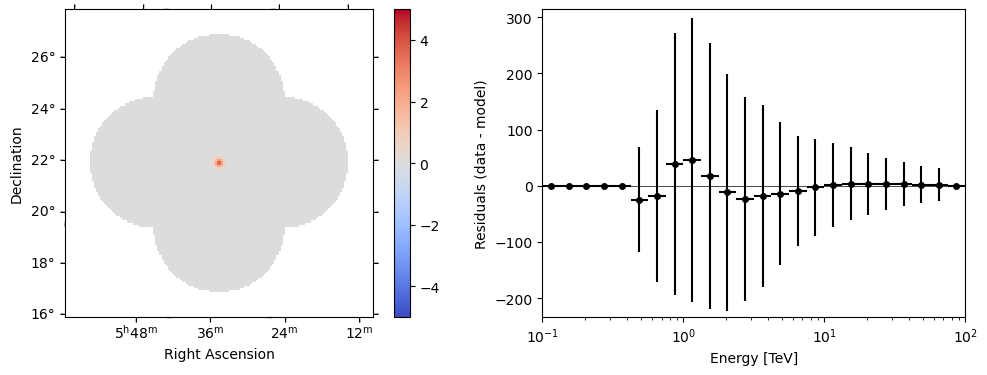

In [14]:
dataset_N.plot_residuals()

['B=0;\n R=1.77']


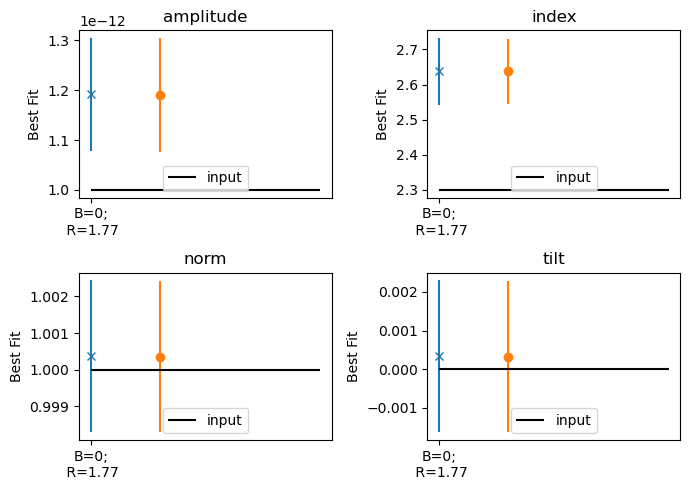

In [15]:
fig,ax  = plt.subplots(2,2,figsize= (7, 5))
ax = ax.flatten()
parnames = ['amplitude', 'index', 'norm', 'tilt']
labels_sys = []

ii =0;
for b in [bias]:
    for s in [sigma]:
        d = dataset
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'x',)
        d = dataset_N
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii+0.3, value, yerr = error, fmt = 'o',)
        ii +=1
        labels_sys.append(f'B={b};\n R={s}')
print(labels_sys)        
for i, p in enumerate(parnames):
    value = dataset_load.models.parameters[p].value
    error = dataset_load.models.parameters[p].error    
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, 0, 1, label = "input", color= 'black')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='lower center',)# bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    #ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(1),labels_sys)
    
plt.tight_layout()
    